# 06 - Apply Doc2Vec to the Governance Data Set
This notebook explores the governance data set using Doc2Vec. Doc2vec might be a good fit for our project as dimensionality reducer.

This code is largely based on [Document-Clustering-Doc2vec](https://github.com/aniketbote/Document-Clustering-Doc2vec/blob/master/Clustering/Clustering_code_Doc2Vec/clustering_Documents_Doc2Vec.py) by [Aniket Bote](https://github.com/aniketbote). We did remove the fixed seed for the randomizer.

Further reading [A gentle introduction to Doc2Vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e) by [Gidi Shperber](https://medium.com/@gidishperber) or [Doc2Vec — Computing Similarity between Documents](https://medium.com/red-buffer/doc2vec-computing-similarity-between-the-documents-47daf6c828cd) by [Abdul Hafeez Fahad](https://medium.com/@a.h.fahad18).


** Kaartje met clusters over gemeenten, dus voor zowel LSA and Doc2Vec een kaartje genereren welke gemeenten in welk cluster zitten
XXX **

---
## Dependencies and Imports
This section deals with fulfilling depenencies and installing the right packages for use in the code below.

Something to keep in mind is that a lot of sample code out there uses Gensum version 3, where we use the current-as-of-this-writing Gensim version 4. The API has changed quite a bit between versions 3 and 4 and sample code may need to be refactored to use the new API before it works. Most changes are in the naming and will cause run-time errors, so finding problems is easy.

In [1]:
!pip install gensim fastparquet

In [2]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'
GZIP='gzip'

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import __version__ as gensim__version__
print(f"gensim=={gensim__version__}")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")

from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")
from sklearn.feature_extraction.text import TfidfVectorizer


python==3.11.4
pandas==2.0.2
gensim==4.3.1
scikit-learn==1.2.2
matplotlib==3.7.1
wordcloud==1.9.2
scikit-learn==1.2.2


---
## Load DV Data Set
This loads the DV data set. We first load as a Panda, because we have the code. Then we make the resultant `corpus` into the list of tagged documents that Gensim is designed to work with.

We also load the municipalities evaluation set. We will use that after clustering with the intention to be able to relate clusters to municipalities.

Finally, we load the document properties. These will help identify document classification issues by looking at the titles.

Spoiler alert, one of the results of outlier detection on our clustering revealed that some documents were misclassified.
The documents below are tagged as duurzaamheidvisie, but are really budget plans.

We found these as visible outliers in on of the clusters. Here we retrieve them by document title. Based on the earlier clustering run we now know what to look for.

In [3]:
DOCUMENT_ID = 'DocID'
DOCUMENT_TITLE = 'Titel'
JAAR = 'Jaar'

documents = pd.read_csv("../data/Governance/Duurzaamheidsvisies.csv", index_col=DOCUMENT_ID)
documents[JAAR] = documents[JAAR].astype(STRING).str.slice(0, 4)

documents[documents[DOCUMENT_TITLE].str.contains("egrot")]


,Titel,Jaar
DocID,,
GM0331DV01,Programmabegroting 2016,2015
GM0852DV01,Programmabegroting 2016,2016
GM0981DV01,Programma begroting 2016,2015


In [4]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


In [5]:
corpus = load_corpus_as_dataframe(GLOB_DV)
corpus.head()


,body
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...
GM0034DV01,verseonnr dagmail december raad gemeente almer...


In [6]:
def make_into_tagged_documents(series):
    return [TaggedDocument(doc.split(' '), [i]) for i, doc in series.items()]

In [7]:
all_content = make_into_tagged_documents(corpus[DOCUMENT_BODY])
for i in range(5):
    print(f"{all_content[i].tags[0]}: {all_content[i].words[:5]}".replace("]", " ..."))

GM0003DV02: ['duurzaamheidsbeleid', 'Appingedam', 'duurzaamheidsbeleid', 'Appingedam', 'Inhoud' ...
GM0005DV01: ['colofon', 'gemeente', 'bedum', 'bezoekadres', 'Schoolstraat' ...
GM0007DV01: ['Milieubeleidsplan', 'vaststellen', 'gemeenteraad', 'bellingweden', 'maart' ...
GM0009DV01: ['inhoud', 'duurzaamheidsvisie', 'februari', 'inhoud', 'inhoud' ...
GM0034DV01: ['verseonnr', 'dagmail', 'december', 'raad', 'gemeente' ...


In [8]:
municipalities = pd.read_parquet("../data/CBS/Evaluation_data.parquet")
municipalities


,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
index,,,,,,,,,,,,,,,,,,,
0,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
1,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
2,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
3,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
4,GM0010,Delfzijl,Groningen,Klein,Arm,weinig stedelijk,Lokaal,Veel,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,GM1940,De Fryske Marren,Fryslân,Middelgroot,Modaal,weinig stedelijk,None,Gemiddeld,Veel,Veel,Gemiddeld,Gemiddeld,Gemiddeld,Middel,Laag,Middel,Middel,iets minder,meer
386,GM1942,Gooise Meren,Noord-Holland,Middelgroot,Rijk,sterk stedelijk,VVD,Geen,Beperkt,Geen,Beperkt,Geen,Beperkt,Hoog,Middel,Middel,Middel,veel lager,iets minder
387,GM1945,Berg en Dal,Gelderland,Middelgroot,Modaal,weinig stedelijk,Lokaal,Geen,Beperkt,Geen,Gemiddeld,Geen,Gemiddeld,Middel,Middel,Middel,Middel,iets minder,iets minder


---
## Train the Doc2Vec Model
With the data cleanly loaded, we can train the model. Since we are very much exploring and since training is relatively fast, we don't save the model. We simply retrain it every time.

One question that came up is whether we migth be overfitting. We have fewer than 300 documents, yet we train towards vectors of 300 dimensions. This is not a problem per se, as the training does not happen on individual documents, but rather on 5-grams of these documents. There are rather more than 300 5-grams.

Another topic we disucssed was whether 

In [9]:
d2v_model = Doc2Vec(all_content, vector_size=300, min_count=5, dm=0, alpha=0.0025, min_alpha=0.0001)
d2v_model.train(all_content, total_examples=d2v_model.corpus_count, epochs=50, start_alpha=0.002, end_alpha=-0.016)


---
## Elbow and Cluster with K-Means
We use the learned vectors to cluster the DV data set again using K-Means clustering. First we run K-Means clustering for different cluster sizes to make the elbow plot. Then we run K-Means to find the optimal number of clusters that we chose based on the elbow plot. We chose 5.


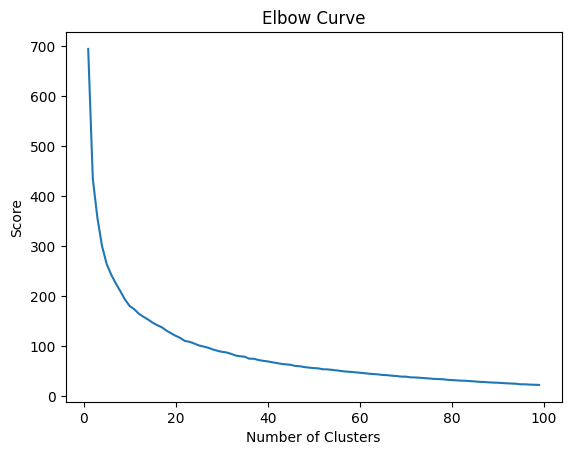

In [10]:
nc = range(1, 100)
kmeans = [KMeans(n_clusters = i, n_init = 100, max_iter = 500) for i in nc]               
score  = [kmeans[i].fit(d2v_model.dv.vectors).inertia_ for i in range(len(kmeans))]

# Plot the elbow
plt.plot(nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


In [11]:
K_value = 5
kmeans_model = KMeans(n_clusters=K_value, n_init='auto') 
kmeans_model.fit(d2v_model.dv.vectors)

# XXX Where should I get clusters, from the model or as a result from predict()?
__clusters = kmeans_model.predict(d2v_model.dv.vectors)
labels = kmeans_model.labels_.tolist()


# // XXX add as dataframe

---
## PCA Analysis and Plotting
We use Principal Component Analysis (PCA) to flatten the 300-dimension document vectors onto a 2D shape for plotting. The banding in the graph below is an artefact of PCA, as the resulting components are not correlated.

In [12]:
# XXX Investigate precisely fit()/predict()/fit_predict().
# Which ones change the internal model state and have side effects?

__l = kmeans_model.fit_predict(d2v_model.dv.vectors)
pca = PCA(n_components=2).fit(d2v_model.dv.vectors)
datapoint = pca.transform(d2v_model.dv.vectors)

# // XXX add to data frame

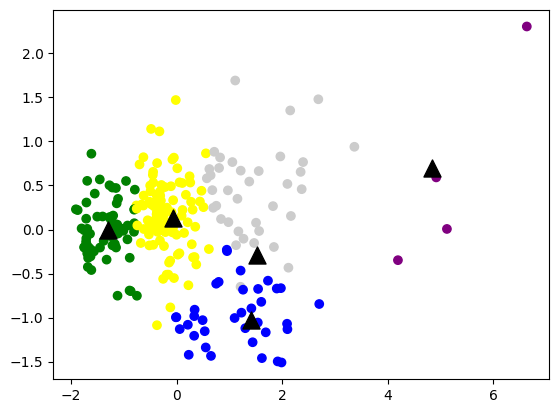

In [13]:
plt.figure
label1 = ["#FFFF00", "#008000", "#0000FF", "#800080", "#cccccc"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

# XXX print the document weigths for each document, sow we can identify them on the plot

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')

plt.show()


---
## Link to Municipality Data
This section three-way merges the clusters we found with the municipality data and document details for evaluation. Municipalities are indexed by their GM-code. Documents by their base file name.

In [14]:
CLUSTER='cluster'
MUNICIPALITY_ID='GM_Code'

kmeans_clusters = pd.DataFrame(index=corpus.index)
kmeans_clusters['DocID'] = corpus.index
kmeans_clusters[CLUSTER] = labels
kmeans_clusters[MUNICIPALITY_ID] = corpus.index.str.slice(0, 6)

kmeans_clusters.head()

,DocID,cluster,GM_Code
GM0003DV02,GM0003DV02,4,GM0003
GM0005DV01,GM0005DV01,2,GM0005
GM0007DV01,GM0007DV01,2,GM0007
GM0009DV01,GM0009DV01,0,GM0009
GM0034DV01,GM0034DV01,0,GM0034


In [15]:
kmeans_clusters_with_municipalities = kmeans_clusters.merge(municipalities, how="left", on=MUNICIPALITY_ID).set_index('DocID')

# the merge adds suffixes to ensure unique column names, so we strip those off
# again since we have no name clashes.
kmeans_clusters_with_municipalities.columns=kmeans_clusters_with_municipalities.columns.str.rstrip('_x') 
kmeans_clusters_with_municipalities.head()


,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,Windenergie_2021,Zonneenergie_2021,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat
DocID,,,,,,,,,,,,,,,,,,,,
GM0003DV02,4,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,Veel,Veel,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder
GM0005DV01,2,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,Veel,Veel,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder
GM0007DV01,2,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,Geen,Veel,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder
GM0009DV01,0,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,Beperkt,Veel,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder
GM0034DV01,0,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,Veel,Veel,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager


In [16]:
kmeans_clusters_with_everything = kmeans_clusters_with_municipalities.join(documents)
kmeans_clusters_with_everything.head()



,cluster,GM_Code,Gemeente,PV,Gemeentegrootte,Inkomens_categorie,Stedelijkheidsgraad,Meeste_zetels,Windenergie_2012,Zonneenergie_2012,...,Windenergie_groei,Zonneenergie_groei,Aardgas_2016_cat,Elektriciteit_2016_cat,Aardgas_2021_cat,Elektriciteit_2021_cat,Aardgas_verschil_cat,Elektriciteit_verschil_cat,Titel,Jaar
DocID,,,,,,,,,,,,,,,,,,,,,
GM0003DV02,4,GM0003,Appingedam,Groningen,Klein,Arm,matig stedelijk,Lokaal,Geen,Beperkt,...,NaN,Veel,Middel,Laag,Middel,Laag,iets minder,iets minder,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,2,GM0005,Bedum,Groningen,Klein,Modaal,weinig stedelijk,Lokaal,Beperkt,Beperkt,...,Veel,Veel,Middel,Laag,Hoog,Laag,iets minder,iets minder,Milieubeleidsplan 2009-2012,2009
GM0007DV01,2,GM0007,Bellingwedde,Groningen,Klein,Laag,niet stedelijk,PvdA,Geen,Beperkt,...,Geen,Veel,Hoog,Middel,Hoog,Middel,iets minder,iets minder,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,0,GM0009,Ten Boer,Groningen,Klein,Modaal,niet stedelijk,Lokaal,Beperkt,Beperkt,...,Geen,Veel,Hoog,Laag,Laag,Laag,veel lager,iets minder,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,0,GM0034,Almere,Flevoland,Groot,Modaal,sterk stedelijk,D66,Veel,Veel,...,Gemiddeld,Veel,Laag,Middel,Laag,Middel,meer,veel lager,Plan van aanpak duurzaamheidsagenda,2010


In [17]:
kmeans_clusters_with_everything.loc[kmeans_clusters_with_everything[CLUSTER]==4, ['GM_Code', 'Gemeente', 'Titel', 'Jaar']]


,GM_Code,Gemeente,Titel,Jaar
DocID,,,,
GM0003DV02,GM0003,Appingedam,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0079DV01,GM0079,Kollumerland en Nieuwkruisland,Duurzaamheid in Noordoost Friesland,<NA>
GM0141DV01,GM0141,Almelo,duurzaamheidsbeleidsplan 2013 - 2016,2013
GM0150DV02,GM0150,Deventer,www.deventer.nl Uitvoeringsagenda Duurzaamheid...,2011
GM0153DV01,GM0153,Enschede,Duurzaamheidsbeleid,2016
GM0166DV01,GM0166,Kampen,Energieplan 2016 - 2020 CONCEPT: Energiebesp...,2016
GM0243DV01,GM0243,Harderwijk,De Energieke Stad Een routekaart naar klimaatn...,2013
GM0268DV01,GM0268,Nijmegen,Duurzaamheid in uitvoering 2013-2017,<NA>
GM0301DV01,GM0301,Zutphen,Beleidsplan Zutphen Energieneutraal 2047,2010


---
## Word Clouds and Word Lists
With the clustered established, we can now make word clouds of each of them. Before we can work with word clouds, we have to merge the K-Means clusters with the original corpus. The word clouds need the text.

In [18]:
corpus_with_cluster = corpus.join(kmeans_clusters)
corpus_with_cluster.head()


,body,DocID,cluster,GM_Code
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003DV02,4,GM0003
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005DV01,2,GM0005
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007DV01,2,GM0007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009DV01,0,GM0009
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034DV01,0,GM0034


In [19]:
MIN_DF=15
MAX_DF=0.95

def document_bodies_in_cluster(corpus, cluster):
    return corpus[corpus[CLUSTER]==cluster][DOCUMENT_BODY]

def nlargest_of(corpus, cluster, n):
    docs = document_bodies_in_cluster(corpus, cluster)

    if len(docs) < MIN_DF:
        print(f"only {len(docs)} documents in cluster {cluster}, setting `min_df` and `max_df` system defaults")
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = TfidfVectorizer(min_df=MIN_DF, max_df=MAX_DF)

    counts = vectorizer.fit_transform(docs)
    totals = counts.sum(0)
    return pd.DataFrame(totals.T, index=vectorizer.get_feature_names_out())[0].nlargest(n)

def print_cluster(corpus, cluster):
    print(nlargest_of(corpus, cluster, 20))

def cloud_of_cluster(corpus, cluster):
    cloud = WordCloud(background_color="white", max_words=20).generate_from_frequencies(nlargest_of(corpus, cluster, 50))
    plt.axis('off')
    plt.imshow(cloud);


eur                 7.052247
gebouw              6.138095
ambitie             6.081417
beleid              5.601312
inwoner             5.560295
energiebesparing    5.452712
doelstelling        5.320455
wij                 4.896928
milieu              4.889063
stad                4.811150
bouwen              4.747382
programma           4.460508
activiteit          4.349589
samen               4.343182
thema               4.331998
uur                 4.217576
afval               4.207683
rol                 4.168384
natuur              4.116698
partij              4.090517
Name: 0, dtype: float64


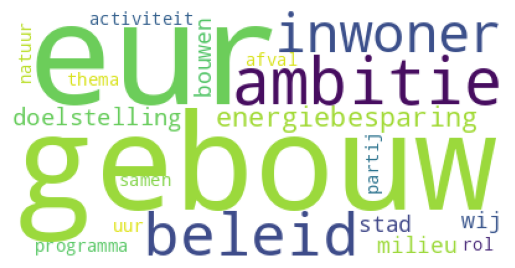

In [20]:
print_cluster(corpus_with_cluster, 0)
cloud_of_cluster(corpus_with_cluster, 0)


duurzaamheid        9.712148
project             8.574226
gemeentelijk        5.790334
eur                 5.611133
ontwikkeling        4.429846
organisatie         4.411999
lokaal              4.217647
energiebesparing    4.197978
moeten              4.146055
goed                4.085856
inwoner             4.065089
wij                 3.929485
thema               3.777735
gebouw              3.699719
maatregel           3.641843
uur                 3.497808
stimuleren          3.495559
rol                 3.455621
uitvoeren           3.431573
activiteit          3.421788
Name: 0, dtype: float64


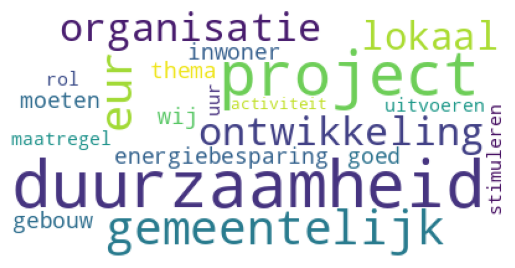

In [21]:
print_cluster(corpus_with_cluster, 1)
cloud_of_cluster(corpus_with_cluster, 1)


milieubeleidsplan       4.273150
afval                   3.717095
extern                  3.467087
veiligheid              3.310703
regionaal               3.090626
milieubeleid            2.894473
duurzaamheid            2.728228
stof                    2.515094
ambitie                 2.411890
bouwen                  2.410588
geluid                  2.407152
water                   2.361356
bodem                   2.191914
gebouw                  2.151057
natuur                  2.141165
programma               1.858454
regio                   1.797938
organisatie             1.766739
uitvoeringsprogramma    1.759072
wel                     1.746254
Name: 0, dtype: float64


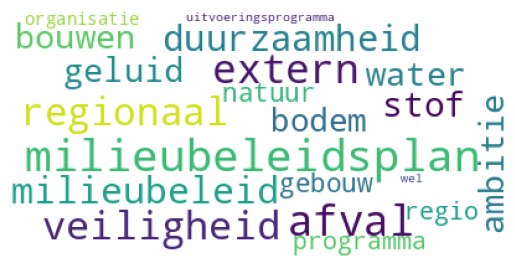

In [22]:
print_cluster(corpus_with_cluster, 2)
cloud_of_cluster(corpus_with_cluster, 2)


only 4 documents in cluster 3, setting `min_df` and `max_df` system defaults
groen                 0.843809
rijswijk              0.834908
parkstad              0.722870
gemeente              0.576229
limburg               0.452064
energie               0.447587
zullen                0.425832
boom                  0.412230
gebied                0.343419
woning                0.319519
bomenatuurecreatie    0.312321
landgoederenzone      0.309414
moeten                0.305448
groenbeleidsplan      0.304432
groot                 0.299317
palet                 0.282875
langs                 0.280221
goed                  0.278684
sector                0.273510
maken                 0.249194
Name: 0, dtype: float64
only 4 documents in cluster 3, setting `min_df` and `max_df` system defaults


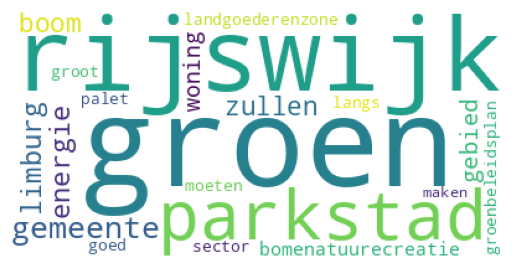

In [23]:
print_cluster(corpus_with_cluster, 3)
cloud_of_cluster(corpus_with_cluster, 3)


stad           3.571677
wij            3.523614
regionaal      2.680021
thema          2.585605
circulair      2.574058
activiteit     2.303164
eur            2.254728
programma      2.194167
mobiliteit     2.130566
milieu         1.968328
sociaal        1.949667
ondernemer     1.941672
wel            1.910396
bijlage        1.804779
bewoner        1.793918
natuur         1.770520
kader          1.742308
samenleving    1.724930
burger         1.712224
product        1.693283
Name: 0, dtype: float64


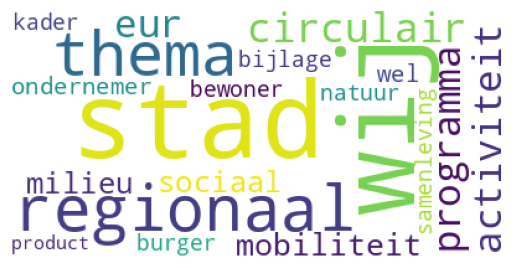

In [24]:
print_cluster(corpus_with_cluster, 4)
cloud_of_cluster(corpus_with_cluster, 4)
